# Solar Power Modelling


The conversion of **solar irradiance to electric power output** as observed in photovoltaic (PV) systems is covered in this chapter of [*AssessingSolar.org*](https://assessingsolar.org/). Other chapters facilitate best practices in how to obtain solar radiation data, how to apply certain quality checks to the data or how to manipulate and assess timeseries of solar data for solar resource assessment. However, for PV applications it is important that we consider the conversion from irradiance to power output occuring between the different components of a PV system and of the PV system as a whole. 

The several sections of this chapter aim to illustrate the conversion from irradiance to power step by step:
- [1 Defining PV system components;](#CharacteristicsPV)
- [2 I-V characteristic curve;](#IVcurve)
- [3 Irradiance to DC power conversion;](#DCmodels)
- [4 DC to AC power conversion (inverter models);](#inverter)
- [5 Whole System Irradiance to Power Conversion.](#fullsystem)

The code in this chapter is mainly based on the Python libraries [*pvlib*](https://pvlib-python.readthedocs.io/en/stable/) and other general purpose libraries, such as [*numpy*](https://numpy.org/), [*pandas*](https://pandas.pydata.org/) and [*matplotlib*](https://matplotlib.org/).

***
<div style="text-align: right"> <i>Content by Javier Lopez Lorente</i> </div>

## 1 Defining PV System Components <a id='CharacteristicsPV'></a>

In this section we cover how to define or obtain the different characteristics and specifications of several components of PV systems, such as PV modules and PV inverters. These components can be defined manually, for example, in Python dictionary or can be retrieved from existing databases.

### Definition of PV module

The characteristics of PV modules in Python can be retrieved by using *pvlib*. The 2 main databases for PV modules that can be imported are: (1) the Sandia Laboratories PV module database; and (2) the CEC PV module database. Below, we present an example to how the databases can be accessed.

In [1]:
# Import the particular module of the pvlib library
from pvlib import pvsystem

# CEC PV Module Database
cec_mod_db = pvsystem.retrieve_sam('CECmod')

# Size of the database
print(cec_mod_db.shape)

(25, 21535)


There are over 21,500 modules in that version of the CEC PV module database. Each module has 25 parameters that are technical information of the module and metadata. The database is returned as a pandas DataFrame, so each of the modules can be accessed with integer-location based indexing using *iloc*. Let's have a look to the parameters of one of them selected randomly:


In [2]:
import numpy as np
print(cec_mod_db.iloc[:, np.random.randint(0, high=len(cec_mod_db))])

Technology            Mono-c-Si
Bifacial                      0
STC                     184.702
PTC                       160.2
A_c                         1.3
Length                    1.576
Width                     0.825
N_s                          72
I_sc_ref                   5.43
V_oc_ref                  44.14
I_mp_ref                   5.03
V_mp_ref                  36.72
alpha_sc               0.002253
beta_oc                -0.15961
T_NOCT                     49.9
a_ref                   1.98482
I_L_ref                 5.43568
I_o_ref             1.16164e-09
R_s                    0.311962
R_sh_ref                298.424
Adjust                  15.6882
gamma_r                 -0.5072
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: A10Green_Technology_A10J_S72_185, dtype: object


The parameters of the CEC database include technology (*string*), bifacial (*boolean*), STC power (*float*), PTC power (*float*), dimensions of the panel, open-circuit and short-circuit specifications, and other technical characteristics including the 5-parameter needed for the single diode equation to estimate the DC power under certain conditions. 

Similarly, the Sandia Laboratories PV module database can be accessed:

In [3]:
# Sandia PV Module Database
sandia_mod_db = pvsystem.retrieve_sam('sandiamod')

# Dimensions
print(sandia_mod_db.shape)


(42, 523)


In [4]:
# Accessing the characteristics of one of the modules randomly
print(sandia_mod_db.iloc[:, np.random.randint(0, high=len(sandia_mod_db))])

Vintage                                                      2002 (E)
Area                                                            0.657
Material                                                      Si-Film
Cells_in_Series                                                    39
Parallel_Strings                                                    1
Isco                                                              3.4
Voco                                                             20.7
Impo                                                                3
Vmpo                                                             16.8
Aisc                                                         0.000552
Aimp                                                         0.000216
C0                                                              0.951
C1                                                              0.049
Bvoco                                                          -0.098
Mbvoc               

We observe that the database of PV modules from Sandia Laboratories includes more technical parameters and information than the CEC module database. However, it contains less modules. Alternatively, you can define a dictionary with the characteristics of the PV module as found in a typical datasheet.

In [5]:
# PV module data from a typical datasheet (e.g. Kyocera Solar KD225GX LPB)
module_data = {'celltype': 'multiSi', # technology
               'STC': 224.99, # STC power
               'PTC': 203.3, # PTC power
               'v_mp': 29.8, # Maximum power voltage
               'i_mp': 7.55, # Maximum power current
               'v_oc': 36.9, # Open-circuit voltage
               'i_sc': 8.18, # Short-circuit current
               'alpha_sc': 0.001636, # Temperature Coeff. Short Circuit Current [A/C]
               'beta_voc': -0.12177, # Temperature Coeff. Open Circuit Voltage [V/C]
               'gamma_pmp': -0.43, # Temperature coefficient of power at maximum point [%/C]
               'cells_in_series': 60, # Number of cells in series
               'temp_ref': 25}  # Reference temperature conditions

### Definition of a PV inverter

Similarly to the database of PV modules, it is possible to access the CEC database of PV inverters.

In [6]:
invdb = pvsystem.retrieve_sam('CECInverter')
print(invdb.shape)

(16, 3264)


There over 3,200 inverters available and each of them has 16 parameters. As in the case of the PV modules, you can define your own PV inverter using a dictionary. Let's have a look to one of those solar inverters.

In [7]:
# Accessing the characteristics of one of the modules randomly
inverter_data = invdb.iloc[:, np.random.randint(0, high=len(invdb))]

print(inverter_data)

Vac                          208
Pso                      1.76944
Paco                         300
Pdco                     312.421
Vdco                          45
C0                      -4.5e-05
C1                     -0.000196
C2                      0.001959
C3                     -0.023725
Pnt                         0.09
Vdcmax                        60
Idcmax                   6.94269
Mppt_low                      30
Mppt_high                     60
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: ABB__MICRO_0_3HV_I_OUTD_US_208__208V_, dtype: object


## 2 I-V Characteristic Curve <a id='IVcurve'></a>

The I-V curve of a PV module is one of the typical technical characteristics often available in datasheets. In this section, we are going to build the I-V characteristic curve of a PV module from the data available in the technical specification sheet. We will use the dictionary *'module_data'* that we have just created in the previous section.

In order to build the I-V curve, we will need several steps until we estimate the 5 input parameters needed to perform the single diode equation that will return the I and V values for given values of effective irradiance and cell/module temperature.

In [8]:
# Import the pvlib library
import pvlib

In [9]:
# 1st step: Estimating the parameters for the CEC single diode model
""" WARNING - This function relies on NREL's SAM tool. So PySAM, its Python API, needs to be installed 
in the same computer. Otherwise, you can expect the following error: 'ImportError if NREL-PySAM is not installed.'
"""
cec_fit_params = pvlib.ivtools.sdm.fit_cec_sam(module_data['celltype'], module_data['v_mp'], module_data['i_mp'],
                                  module_data['v_oc'], module_data['i_sc'], module_data['alpha_sc'],
                                  module_data['beta_voc'], module_data['gamma_pmp'], 
                                  module_data['cells_in_series'], module_data['temp_ref'])

# Let's have a look to the output
print(cec_fit_params)

(8.202934970033095, 1.0116474533318072e-10, 0.35799019877176264, 127.68099994564776, 1.471122011098777, 1.0522774079781079)


We observe that the output of the function are 6 *float* elements. The documentation of *pvlib* indicates that these correspond to reference conditions values for:

1. Light-generated current (i_l_ref) in Amps;
2. Diode reverse saturation current (i_o_ref) in Amps;
3. Series resistance (r_s) in Ohms;
4. Shunt resistance (r_sh_ref) in Ohms;
5. The product of the diode ideality factor, number of cells in series and cell thermal voltage (a_ref); and
6. The adjustment to the temperature coefficient for short-circuit current in percentage (adjust).

After this step, we have an extended set of technical characteristics of the PV module. We could skip this step if we had these data at the beginning, e.g. by using a PV module from the CEC or Sandia databases.  


We will now define several reference conditions of effective irradiance and average cell temperature values for which to estimate the I-V curve. Then, the second step is estimating the 5 input parameters to be used in the Single Diode Equation:

In [10]:
# Effective irradiance values (W/m2)
irrad = np.array([200,400,600,800,1000])
# Average cell temperature (degrees Celsius)
temp_cell = np.array([40, 40, 40, 40, 40])

# 2nd step: Apply model to estimate the 5 parameters of the single diode equation using the CEC model
diode_params = pvlib.pvsystem.calcparams_cec(irrad, temp_cell, module_data['alpha_sc'], cec_fit_params[4], 
                                            cec_fit_params[0], cec_fit_params[1], cec_fit_params[3], 
                                            cec_fit_params[2], cec_fit_params[5])

# The result of the function returns a Tuple of 5 parameters to be used in the single diode equation
print('Number of elements returned: ', len(diode_params))

Number of elements returned:  5


In [11]:
# Let's have a look to the tuple:
print(diode_params)

(array([1.64544335, 3.2908867 , 4.93633004, 6.58177339, 8.22721674]), array([1.1196491e-09, 1.1196491e-09, 1.1196491e-09, 1.1196491e-09,
       1.1196491e-09]), 0.35799019877176264, array([638.40499973, 319.20249986, 212.80166658, 159.60124993,
       127.68099995]), array([1.54513452, 1.54513452, 1.54513452, 1.54513452, 1.54513452]))


Finally, we can estimate the **I-V characteristic of the PV module**:

In [12]:
# Estimate I-V characteristic using the Single Diode Equation
iv_values1 = pvlib.pvsystem.singlediode(diode_params[0], 
                                        diode_params[1], 
                                        diode_params[2], 
                                        diode_params[3], 
                                        diode_params[4], 
                                        ivcurve_pnts=25,   # Number of points of the I-V curve (equally distributed)
                                        method='lambertw') # I-V using the Lambert W. function

# The result is a large ordered dictionary with the IV-curve characteristics of our example.
print(iv_values1.keys())

odict_keys(['i_sc', 'v_oc', 'i_mp', 'v_mp', 'p_mp', 'i_x', 'i_xx', 'v', 'i'])


We can then visualize the I-V characteristic of our PV module and the given reference conditions:

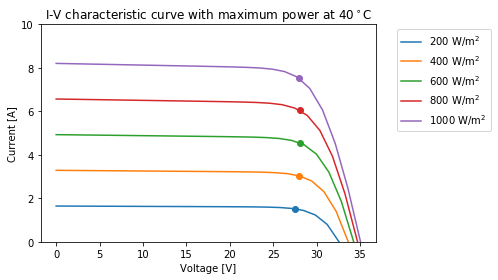

In [14]:

# Importing our library for plotting and visualization
import matplotlib.pyplot as plt

# We iterate over voltage
for i in range(len(irrad)):
    plt.plot(iv_values1['v'][i], iv_values1['i'][i], label=str(irrad[i])+' W/m$^2$')
    plt.scatter(iv_values1['v_mp'][i], iv_values1['i_mp'][i])
# Add the title, axis labels and legend: 
plt.title('I-V characteristic curve with maximum power at 40$^\circ$C')
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.ylim(0, 10)
plt.legend(bbox_to_anchor=(1.05, 1), ncol=1)

Following on the assessment of the I-V curve of a PV module, it is possible to analyse the *effect of temperature in the PV module performance*. Below, an example of I-V curve is shown for an effective irradiance of 800 W/m$^2$ with different average cell temperatures:




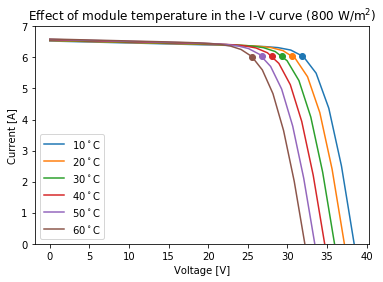

In [15]:
# Effective irradiance values (W/m2)
irrad = np.array([800, 800, 800, 800, 800, 800])
# Average cell temperature (degrees Celsius)
temp_cell = np.array([10, 20, 30, 40, 50, 60])

# Repeating the process from before:
# Estimate the 5 parameters of the single diode equation using the CEC model
diode_params = pvlib.pvsystem.calcparams_cec(irrad, temp_cell, module_data['alpha_sc'], cec_fit_params[4], 
                                            cec_fit_params[0], cec_fit_params[1], cec_fit_params[3], 
                                            cec_fit_params[2], cec_fit_params[5])

# Estimate I-V characteristic using the Single Diode Equation
iv_values2 = pvlib.pvsystem.singlediode(diode_params[0], 
                                        diode_params[1], 
                                        diode_params[2], 
                                        diode_params[3], 
                                        diode_params[4], 
                                        ivcurve_pnts=25,   # Number of points of the I-V curve (equally distributed)
                                        method='lambertw') # I-V using the Lambert W. function

# Plotting the results
for i in range(len(irrad)):
    plt.plot(iv_values2['v'][i], iv_values2['i'][i], label=str(temp_cell[i])+'$^\circ$C')
    plt.scatter(iv_values2['v_mp'][i], iv_values2['i_mp'][i])
# Add the title, axis labels and legend: 
plt.title('Effect of module temperature in the I-V curve (800 W/m$^2$)')
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.ylim(0, 7)
plt.legend(ncol=1)

## 3 Irradiance to DC power conversion <a id='DCmodels'></a>

The production of DC power output of the PV module given by certain conditions of effective irradiance and cell temperature can be estimated in a straight-away manner by using  NREL’s PVWatts DC power model (*pvwatts_dc*), which is available within *pvlib*. An example is presented below:

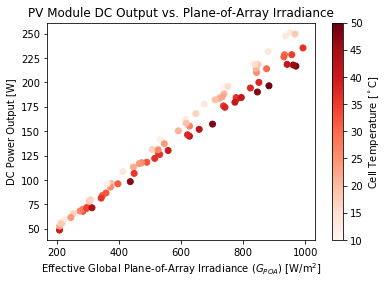

In [16]:
# Randomly define a set of Effective Irradiance and cell temperature values:

# Global plane-of-array effective irradiance between 200 and 1000 W/m2
g_poa_effective = np.random.uniform(low=200, high=1000, size=(80,))
# Mean cell temperature values between 10 and 50 degrees Celsius
temp_cell = np.random.uniform(low=10, high=50, size=(80,)) 

# Definition of PV module characteristics:
pdc0 = 250 # STC power
gamma_pdc = -0.0045 # The temperature coefficient in units of 1/C

# Estimate DC power with PVWatts model
dc_power = pvlib.pvsystem.pvwatts_dc(g_poa_effective, temp_cell, pdc0, gamma_pdc, temp_ref=25.0)

# Let's visualize the DC power output as function of the effective irradiance
plt.scatter(g_poa_effective, dc_power, c=temp_cell, vmin=10, vmax=50, cmap='Reds')
cbar = plt.colorbar()
cbar.set_label('Cell Temperature [$^\circ$C]')
plt.title('PV Module DC Output vs. Plane-of-Array Irradiance')
plt.xlabel('Effective Global Plane-of-Array Irradiance ($G_{POA}$) [W/m$^2$]')
plt.ylabel('DC Power Output [W]')
plt.show()

We can observe the linear relationship between incident effective irradiance and DC power, and how cell temperature has a negative impact on the performance of the PV module. Overall, the lower the module's temperature, the higher the PV output for a given irradiance level.

## 4 DC to AC power conversion (inverter models) <a id='inverter'></a>

Once the DC power is available, the AC power output can be estimated. The inverter is the PV element that implementes the power conversion from DC to AC. An example is shown below where we will use the DataFrame '*inverter_data*' and the dictionary '*iv_values1*' resulted from sections 1 and 2, respectively. 

Let's recall and have a look to the keys available in those elements:

In [17]:
# The DataFrame with the technical characteristics of the PV inverter
inverter_data.keys()

Index(['Vac', 'Pso', 'Paco', 'Pdco', 'Vdco', 'C0', 'C1', 'C2', 'C3', 'Pnt',
       'Vdcmax', 'Idcmax', 'Mppt_low', 'Mppt_high', 'CEC_Date', 'CEC_Type'],
      dtype='object')

In [18]:
# The dictionary with the current and voltage values
iv_values1.keys()

odict_keys(['i_sc', 'v_oc', 'i_mp', 'v_mp', 'p_mp', 'i_x', 'i_xx', 'v', 'i'])

In [19]:
# Estimate AC power from DC power using the Sandia Model
ac_power = pvlib.inverter.sandia(iv_values1['v_mp'], # DC voltage input to the inverter
                                 iv_values1['p_mp'], # DC power input to the inverter
                                 inverter_data) # Parameters for the inverter 
# Estimated Power Output
ac_power

array([ 39.16721703,  81.25576537, 122.67628941, 163.04035011,
       202.17677308])

The result is an array of 5 elements expressed in Watts. It is worth noting that the inverter requires starting power, which is denoted by 'Pso' in the dictionary. 



In [20]:
# Let's check the start DC power required for the inversion process (or self-consumption of the inverter)
inverter_data['Pso']

1.7694439999999998

## 5 Whole System Irradiance to Power Conversion <a id='fullsystem'></a>

The previous section have shown the conversion irradiance to power step-by-step. The library *pvlib* has an alternative method to estimate the AC power output in a more straight-forward way by using the *pvlib* classes *PVSystem* and *ModelChain*.

This section presents an example to estimate the AC power directly using real weather data. The example below uses weather data from a [station](https://midcdmz.nrel.gov/apps/sitehome.pl?site=UOSMRL) located at the University of Oregon, which belongs to the Measurement and Instrumentation Data Center (MIDC) of the U.S. National Renewable Energy Laboratory (NREL). The data used are 1-minute GHI, DHI, DNI, ambient temperature and wind speed measurements for one day in June 2021 (Vignola and Andreas, 2013).

**Retrieving real weather data:**

In [21]:
import pandas as pd
# Let's read the weather data from the MIDC station using the I/O tools available within pvlib
df_weather = pvlib.iotools.read_midc_raw_data_from_nrel('UOSMRL',               # Station id
                                                    pd.Timestamp('20210601'),   # Start date YYYYMMDD
                                                    pd.Timestamp('20210601'))   # End date  YYYYMMDD

# Let's see the head, shape and columns of the data
df_weather.head(3)

,Unnamed: 0,Year,DOY,PST,Unnamed: 4,Direct NIP [W/m^2],Diffuse Schenk [W/m^2],Global LI-200 [W/m^2],Relative Humidity [%],Air Temperature [deg C],...,CHP1 Temp [deg K],CMP22 Temp [deg K],Avg Wind Direction @ 10m [deg from N],Zenith Angle [degrees],Azimuth Angle [degrees],Airmass,Solar Eclipse Shading,Direct SAMPA/Bird (calc) [W/m^2],Global SAMPA/Bird (calc) [W/m^2],Diffuse SAMPA/Bird (calc) [W/m^2]
2021-06-01 00:00:00-08:00,0,2021,152,0,-7999,-0.453,-1.129,0.157,58.95,19.89,...,292.8,294.6,41.59,113.81644,357.43310,-1.0,0,0.0,0.0,0.0
2021-06-01 00:01:00-08:00,0,2021,152,1,-7999,-0.482,-1.150,0.154,59.13,19.79,...,292.8,294.6,64.06,113.82399,357.68613,-1.0,0,0.0,0.0,0.0
2021-06-01 00:02:00-08:00,0,2021,152,2,-7999,-0.575,-1.174,0.134,59.76,19.70,...,292.7,294.5,63.20,113.83076,357.93921,-1.0,0,0.0,0.0,0.0


In [22]:
df_weather.shape

(1437, 29)

In [23]:
df_weather.columns

Index(['Unnamed: 0', 'Year', 'DOY', 'PST', 'Unnamed: 4', 'Direct NIP [W/m^2]',
       'Diffuse Schenk [W/m^2]', 'Global LI-200 [W/m^2]',
       'Relative Humidity [%]', 'Air Temperature [deg C]',
       'Avg Wind Speed @ 10m [m/s]', 'Station Pressure [mBar]',
       'Downwelling IR PIR [W/m^2]', 'Instrument Net PIR [W/m^2]',
       'PIR Case Temp [deg K]', 'PIR Dome Temp [deg K]',
       'Logger Battery [VDC]', 'Direct CHP1 [W/m^2]', 'Global CMP22 [W/m^2]',
       'CHP1 Temp [deg K]', 'CMP22 Temp [deg K]',
       'Avg Wind Direction @ 10m [deg from N]', 'Zenith Angle [degrees]',
       'Azimuth Angle [degrees]', 'Airmass', 'Solar Eclipse Shading',
       'Direct SAMPA/Bird (calc) [W/m^2]', 'Global SAMPA/Bird (calc) [W/m^2]',
       'Diffuse SAMPA/Bird (calc) [W/m^2]'],
      dtype='object')

The DataFrame of weather data provides more many variables (29 variables) than those needed (i.e., irradiance components, ambient temperature and wind speed) to estimate the equivalent AC power of a PV system.

In [24]:
# Subset variables needed
df_weather = df_weather[['Global CMP22 [W/m^2]', 'Diffuse Schenk [W/m^2]', 
                         'Direct CHP1 [W/m^2]','Air Temperature [deg C]', 'Avg Wind Speed @ 10m [m/s]']]
# Rename the columns
df_weather.columns = ['ghi', 'dhi', 'dni', 'temp_air', 'wind_speed']

# See the first columns of our weather dataset
df_weather.head(3)

,ghi,dhi,dni,temp_air,wind_speed
2021-06-01 00:00:00-08:00,-0.391,-1.129,0.425,19.89,0.200
2021-06-01 00:01:00-08:00,-0.391,-1.150,0.411,19.79,0.312
2021-06-01 00:02:00-08:00,-0.401,-1.174,0.425,19.70,0.250


For the example, the surface tilt will be 30$^\circ$, and a surface_azimuth of 180$^\circ$ (south orientation).

Let's define the basics parameters within the *PVSystem* and *ModelChain* classes:

**Definining the characteristics of the PV system:**

In [25]:
# Coordinates of the weather station at University of Oregon (SRML)
latitude = 44.0467
longitude = -123.0743
altitude = 133.8

# Define the location object
location = pvlib.location.Location(latitude, longitude, altitude=altitude)

# Define Temperature Paremeters 
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# Define the PV Module and the Inverter from the CEC databases (For example, the first entry of the databases)
module_data = cec_mod_db.iloc[:,0]

# Define the basics of the class PVSystem
system = pvlib.pvsystem.PVSystem(surface_tilt=30, surface_azimuth=180,
                                 module_parameters=module_data,
                                 inverter_parameters=inverter_data,
                                 temperature_model_parameters=temperature_model_parameters)

# Creation of the ModelChain object
""" The example does not consider AOI losses nor irradiance spectral losses"""
mc = pvlib.modelchain.ModelChain(system, location, 
                                 aoi_model='no_loss', 
                                 spectral_model='no_loss',
                                 name='AssessingSolar_PV')

# Have a look to the ModelChain
print(mc)

ModelChain: 
  name: AssessingSolar_PV
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: no_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses


**Running the model with the weather data:**

In [26]:
# Pass the weather data to the model
""" 
The weather DataFrame must include the irradiance components with the names 'dni', 'ghi', and 'dhi'. 
The air temperature named 'temp_air' in degree Celsius and wind speed 'wind_speed' in m/s are optional.
"""
mc.run_model(df_weather) 

ModelChain: 
  name: AssessingSolar_PV
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: no_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

**Accessing the results of the model:**

After running the model with the weather data, the results can be accessed with the method '*results*'. There are multiple sets of results that can be accessed, some of them are: the weather data 'weather'; the solar position 'solar_position'; the plane-of-array irradiance components 'total_irrad'; the DC power output 'dc'; or the AC power output 'ac'. 

Let's have a look how that can be done:

In [27]:
# Access the weather data
mc.results.weather

,ghi,dhi,dni,wind_speed,temp_air
2021-06-01 00:00:00-08:00,-0.391,-1.129,0.425,0.200,19.89
2021-06-01 00:01:00-08:00,-0.391,-1.150,0.411,0.312,19.79
2021-06-01 00:02:00-08:00,-0.401,-1.174,0.425,0.250,19.70
2021-06-01 00:03:00-08:00,-0.414,-1.185,0.425,0.375,19.67
2021-06-01 00:04:00-08:00,-0.420,-1.182,0.425,0.300,19.59
...,...,...,...,...,...
2021-06-01 23:55:00-08:00,-0.299,-0.849,0.425,0.200,22.74
2021-06-01 23:56:00-08:00,-0.295,-0.838,0.425,0.200,22.75
2021-06-01 23:57:00-08:00,-0.300,-0.865,0.425,0.200,22.74
2021-06-01 23:58:00-08:00,-0.299,-0.952,0.425,0.200,22.77


This returns the same DataFrame 'df_weather' that we had passed to the model.

In [28]:
# Access the solar position at each timestamp
mc.results.solar_position

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2021-06-01 00:00:00-08:00,113.816399,113.816399,-23.816399,-23.816399,357.431855,2.157534
2021-06-01 00:01:00-08:00,113.823961,113.823961,-23.823961,-23.823961,357.684892,2.157427
2021-06-01 00:02:00-08:00,113.830729,113.830729,-23.830729,-23.830729,357.937970,2.157321
2021-06-01 00:03:00-08:00,113.836705,113.836705,-23.836705,-23.836705,358.191084,2.157214
2021-06-01 00:04:00-08:00,113.841887,113.841887,-23.841887,-23.841887,358.444229,2.157107
...,...,...,...,...,...,...
2021-06-01 23:55:00-08:00,113.634624,113.634624,-23.634624,-23.634624,356.135134,2.000772
2021-06-01 23:56:00-08:00,113.646251,113.646251,-23.646251,-23.646251,356.387404,2.000661
2021-06-01 23:57:00-08:00,113.657089,113.657089,-23.657089,-23.657089,356.639737,2.000549
2021-06-01 23:58:00-08:00,113.667137,113.667137,-23.667137,-23.667137,356.892129,2.000438


The solar position returns the zenith, solar elevation, azimuth angles and the equation of time.

In [29]:
# Access Plane-of-array Irradiances
mc.results.total_irrad

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2021-06-01 00:00:00-08:00,-0.006548,0.0,-0.006548,0.0,-0.006548
2021-06-01 00:01:00-08:00,-0.006548,0.0,-0.006548,0.0,-0.006548
2021-06-01 00:02:00-08:00,-0.006715,0.0,-0.006715,0.0,-0.006715
2021-06-01 00:03:00-08:00,-0.006933,0.0,-0.006933,0.0,-0.006933
2021-06-01 00:04:00-08:00,-0.007034,0.0,-0.007034,0.0,-0.007034
...,...,...,...,...,...
2021-06-01 23:55:00-08:00,-0.005007,0.0,-0.005007,0.0,-0.005007
2021-06-01 23:56:00-08:00,-0.004940,0.0,-0.004940,0.0,-0.004940
2021-06-01 23:57:00-08:00,-0.005024,0.0,-0.005024,0.0,-0.005024
2021-06-01 23:58:00-08:00,-0.005007,0.0,-0.005007,0.0,-0.005007


The results for the plane-of-array irradiance returns the global POA irradiance and its components at the designated tilt and azimuth angle of the PV system and estimated with the method designated in ModelChain.

Let's see how to access the DC and AC power output of the PV system:

In [30]:
# Access the DC power output
mc.results.dc

,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx
2021-06-01 00:00:00-08:00,-0.000034,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-01 00:01:00-08:00,-0.000034,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-01 00:02:00-08:00,-0.000035,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-01 00:03:00-08:00,-0.000036,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-01 00:04:00-08:00,-0.000036,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2021-06-01 23:55:00-08:00,-0.000026,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-01 23:56:00-08:00,-0.000026,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-01 23:57:00-08:00,-0.000026,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-01 23:58:00-08:00,-0.000026,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Access the AC power output
mc.results.ac

2021-06-01 00:00:00-08:00   -0.09
2021-06-01 00:01:00-08:00   -0.09
2021-06-01 00:02:00-08:00   -0.09
2021-06-01 00:03:00-08:00   -0.09
2021-06-01 00:04:00-08:00   -0.09
                             ... 
2021-06-01 23:55:00-08:00   -0.09
2021-06-01 23:56:00-08:00   -0.09
2021-06-01 23:57:00-08:00   -0.09
2021-06-01 23:58:00-08:00   -0.09
2021-06-01 23:59:00-08:00   -0.09
Length: 1437, dtype: float64

**Analyzing and visualizing the results:**

With all the set of results, we can analyze and visualize the results of the PV system.

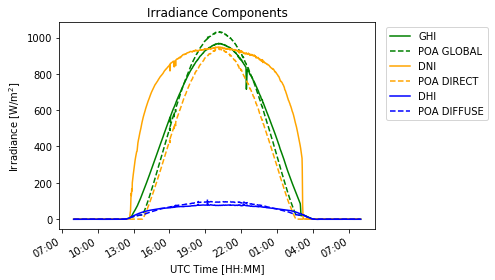

In [32]:
from matplotlib.dates import DateFormatter

# Define labels of variables to plot and colors 
irrad_labels = ['ghi', 'dni', 'dhi']
poa_labels = ['poa_global', 'poa_direct', 'poa_diffuse']
colors = ['green', 'orange', 'blue']

# Plot of Irradiance Variables
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(irrad_labels)):
    mc.results.weather[irrad_labels[i]].plot(label=irrad_labels[i].upper(), color=colors[i])
    ax = mc.results.total_irrad[poa_labels[i]].plot(label=poa_labels[i].upper().replace('_', ' '), color=colors[i], ls='--')
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax.set_ylabel('Irradiance [W/m$^2$]')
ax.set_xlabel('UTC Time [HH:MM]')
ax.set_title('Irradiance Components')
plt.legend(bbox_to_anchor=(1.02,1))
plt.tight_layout()
plt.show() 

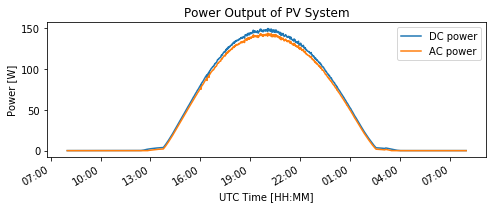

In [33]:
# Plot of Power Output 
fig, ax = plt.subplots(figsize=(7, 3))

mc.results.dc['p_mp'].plot(label='DC power')
ax = mc.results.ac.plot(label='AC power')
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax.set_ylabel('Power [W]')
ax.set_xlabel('UTC Time [HH:MM]')
ax.set_title('Power Output of PV System')
plt.legend()
plt.tight_layout()
plt.show() 

With the power output data, it is possible to assess the amount of solar energy generated in the period of time assessed:

In [34]:
# Estimate solar energy available and generated
poa_energy = mc.results.total_irrad['poa_global'].sum()*(1/60)/1000 # Daily POA irradiation in kWh
dc_energy = mc.results.dc['p_mp'].sum()*(1/60)/1000 # Daily DC energy in kWh
ac_energy = mc.results.ac.sum()*(1/60)/1000 # Daily AC energy in kWh

print('*'*15, ' Daily Production ','*'*15,'\n','-'*48) 
print('\tPOA irradiation: ', "%.2f" % poa_energy, 'kWh')
print('\tInstalled PV Capacity: ', "%.2f" % module_data['STC'], 'W')
print('\tDC generation:', "%.2f" % dc_energy, 'kWh (','%.2f'%(dc_energy*1000/module_data['STC']), 'kWh/kWp)')
print('\tAC generation:', "%.2f" % ac_energy, 'kWh (','%.2f'%(ac_energy*1000/module_data['STC']), 'kWh/kWp)')
print('-'*50)

***************  Daily Production  *************** 
 ------------------------------------------------
	POA irradiation:  8.11 kWh
	Installed PV Capacity:  175.09 W
	DC generation: 1.20 kWh ( 6.88 kWh/kWp)
	AC generation: 1.15 kWh ( 6.55 kWh/kWp)
--------------------------------------------------


## Section Summary
This section has looked at the **conversion from irradiance to power output in a PV system**. Multiple examples have been presented illustrating: 
- how to access data of PV components such as PV modules and inverters; 
- how to estimate and visualize the I-V curve of a PV module under certain irradiance and temperature conditions; and
- how to estimate and visualize the DC and AC power output from irradiance data. 

The code provided in the examples can help you as a starting point to assess other solar systems by adapting the characteristics and particularising to your case study.

## References
Vignola, F.; Andreas, A.; (2013). University of Oregon: GPS-based Precipitable Water Vapor (Data); NREL Report No. DA-5500-64452. http://dx.doi.org/10.7799/1183467